# Object Detection Pipeline

In [1]:
#import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

#parameter definitions
shape = (1, 224, 224, 3)
targetSize = (224,224)
rgbMaxValue = 255.0
figSize = (10,8)
rectangleColor = (0, 255, 0) # green color
path = './dataset/test_images/2.jpg'

# limit gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# importing load_img and img_to_array from tensorflow keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
#Write code for loading the object detection model trained before
model = tf.keras.models.load_model('./model/object_detection.h5', custom_objects={"f1_m": f1_m, "precision_m" : precision_m, "recall_m": recall_m })
print('Model loaded sucessfully')

Model loaded sucessfully


In [5]:
#load image to python
image = load_img(path) # PIL object

#create a numpy array of 8 bits (0, 255)
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)

#load the image and resize the image to 224,224
image1 = load_img(path,target_size=(targetSize))

#convert into array and get the normalized output
image_arr_224 = img_to_array(image1)/rgbMaxValue

In [6]:
# get the size of the orginal image
h, w, d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 1280
Width of the image = 2560


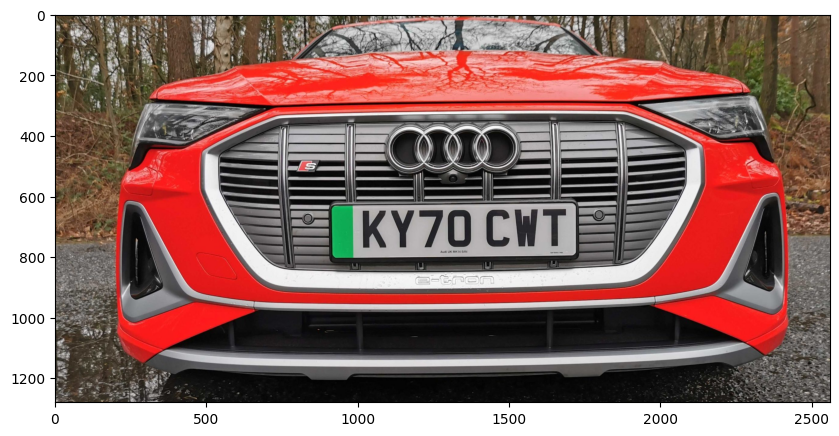

In [7]:
#ploting the image
plt.figure(figsize=figSize)
plt.imshow(image)
plt.show()

In [8]:
#chech image array shape
image_arr_224.shape

(224, 224, 3)

In [9]:
# assign a test_arr variable and reshape it to can test it with the model
test_arr = image_arr_224.reshape(shape)
#checking the test_arr shape
test_arr.shape

(1, 224, 224, 3)

# Making predictions

In [10]:
# Assign a var coords and use predict using the model
coords = model.predict(test_arr)

#print the predicted coords
coords

1/1 [==============================] - 6s 6s/step


array([[0.21451752, 0.75561947, 0.48035926, 0.68225765]], dtype=float32)

In [11]:
# Denormalize the value because the training was used with normalized values
denorm = np.array([w,w,h,h])
coords = coords * denorm

#print the denormlized values
coords

array([[ 549.16484833, 1934.38583374,  614.85984802,  873.28979492]])

In [12]:
# convert the coords to int32
coords = coords.astype(np.int32)
coords

array([[ 549, 1934,  614,  873]])

(549, 614) (1934, 873)


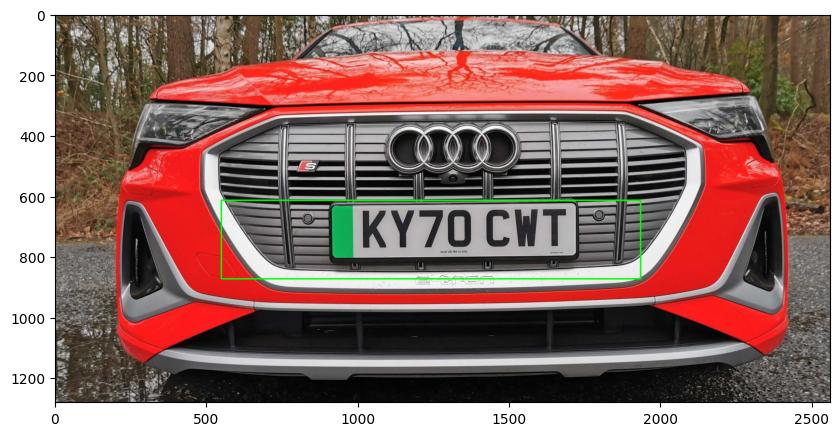

In [13]:
# draw bounding box on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)
cv2.rectangle(image,pt1,pt2,(rectangleColor),3)

plt.figure(figsize=figSize)
plt.imshow(image)
plt.show()

In [14]:
# create a pipeline defined as object_detection using the previous code
def object_detection(path):
    # read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=targetSize)
    # data preprocessing
    image_arr_224 = img_to_array(image1)/rgbMaxValue  # convert into array and get the normalized output
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(shape)
    # make predictions
    coords = model.predict(test_arr)
    # denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    # draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(rectangleColor),3)
    return image, coords

1/1 [==============================] - 0s 40ms/step
(549, 614) (1934, 873)


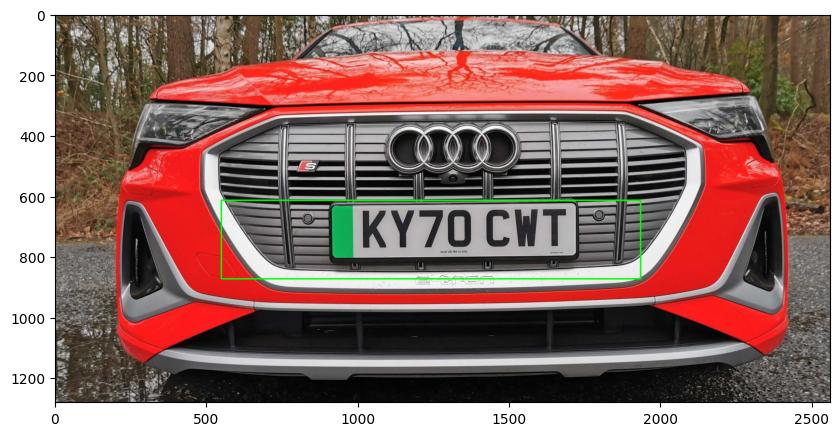

In [15]:
image, cords = object_detection(path)

plt.figure(figsize=figSize)
plt.imshow(image)
plt.show()

# Optical Character Recognition - OCR

In [16]:
# import pytesseract
import pytesseract as pt

1/1 [==============================] - 0s 37ms/step
(549, 614) (1934, 873)


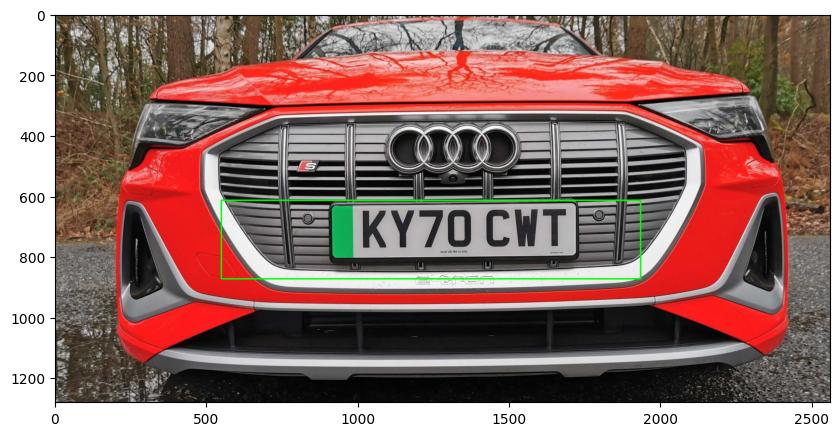

In [17]:
# pass the image to the object_detection function
image, cords = object_detection(path)

#plot the image
plt.figure(figsize=figSize)
plt.imshow(image)
plt.show()

In [18]:
# crop the image based on the predicted values
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cords[0]
roi = img[ymin:ymax,xmin:xmax]

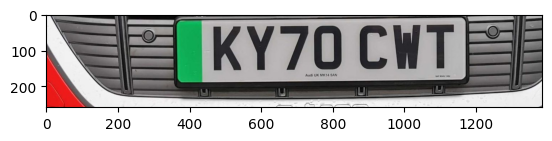

In [19]:
# plot the image
plt.imshow(roi)
plt.show()

In [20]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

In [21]:
# CLear GPU memory (my sanity check)
tf.keras.backend.clear_session()